## Support Vector Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Support Vector Classifier model.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp

## IMPORT DATA

In [2]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))

y = pd.read_csv('02.data/target_categories.csv', header=None, squeeze=True)

In [3]:
X = features.drop('reportable_comp', axis=1)

In [4]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## Support Vector Classifier

In [5]:
scaler = StandardScaler()
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)

# must convert to array and reshape
# otherwise error message
# y = sc_y.fit_transform(np.array(y).reshape(-1, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
svc = SVC(kernel='rbf')

In [8]:
# cross_val_score(svr, X, y, cv=3)

In [9]:
svc.fit(X_train, y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
svc.score(X_test, y_test)

0.23345641621374932

SVC has performed worse than any of the other models.

In [17]:
pred = svc.predict(X_test)
actual = y_test

In [18]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(actual, pred) / \
confusion_matrix(actual, pred).sum(axis=1, keepdims=True)

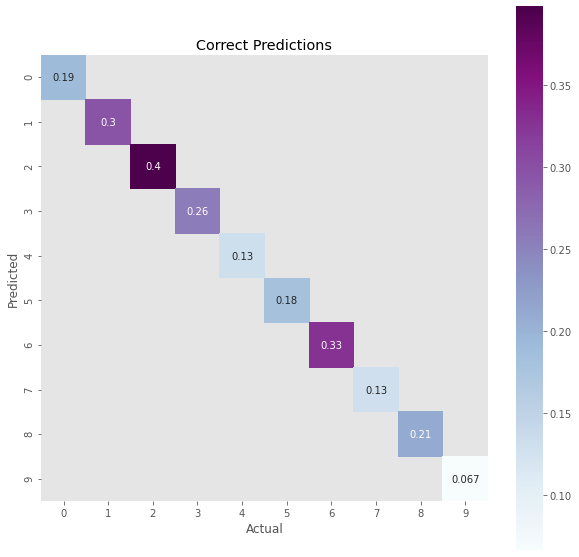

In [19]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(pd.DataFrame(np.diagflat(np.diagonal(pd.DataFrame(norm_conf_matrix)))).replace(0, np.nan),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Correct Predictions');

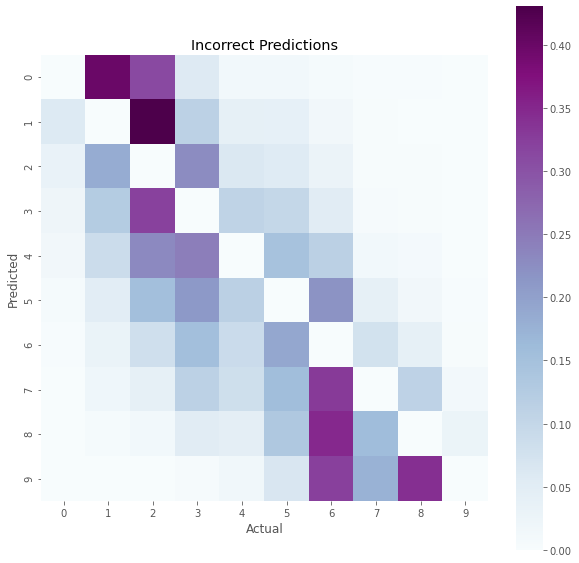

In [20]:
# compare features using a heatmap
plt.figure(figsize=(10, 10))
np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=False, 
                 cmap='BuPu')

plt.ylabel('Predicted')
plt.xlabel('Actual');
plt.title('Incorrect Predictions');

Interesting how SVC struggled most with classifiction for categories on the smaller end of the spectrum.

### Examine precision/recall thresholds
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [23]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=y.unique())
n_classes = Y.shape[1]

In [24]:
# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [ ]:
# Run classifier
classifier = OneVsRestClassifier(svc)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [16]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.18


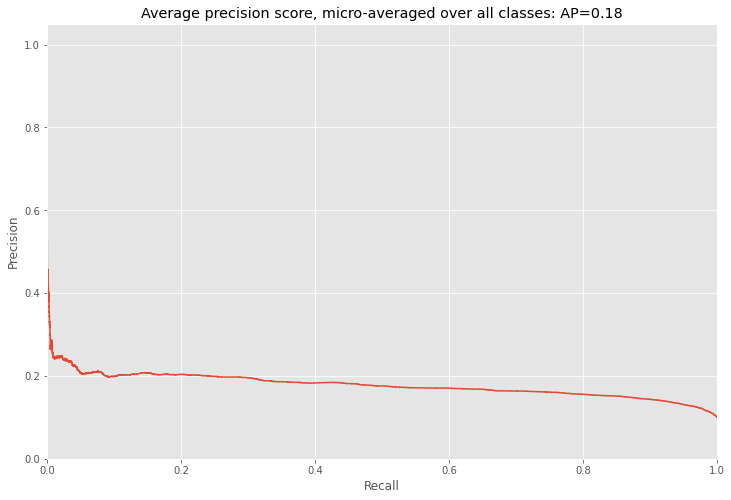

In [17]:
plt.figure(figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]));

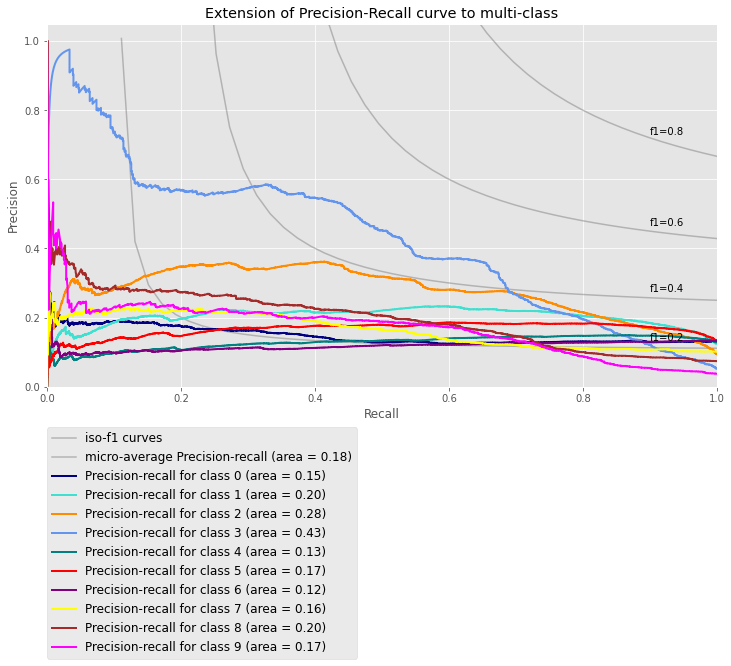

In [18]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.5)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
# l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.75), prop=dict(size=12))

plt.show();

### Examine ROC curve thresholds 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [19]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

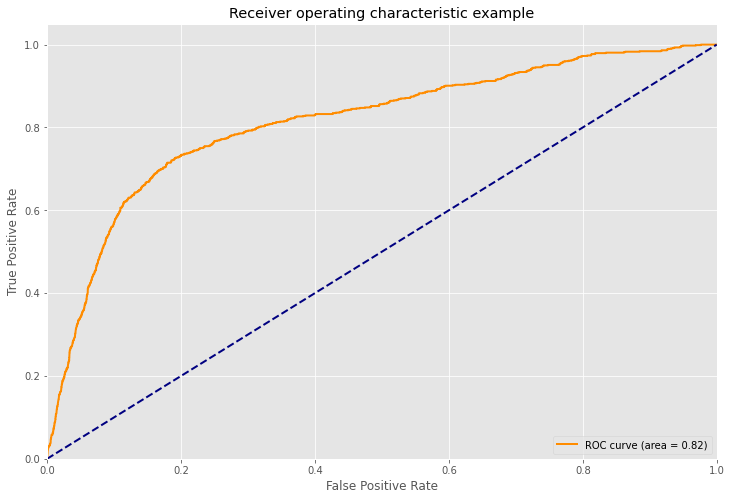

In [20]:
# plot ROC curve for specific classes
plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr[9], tpr[9], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

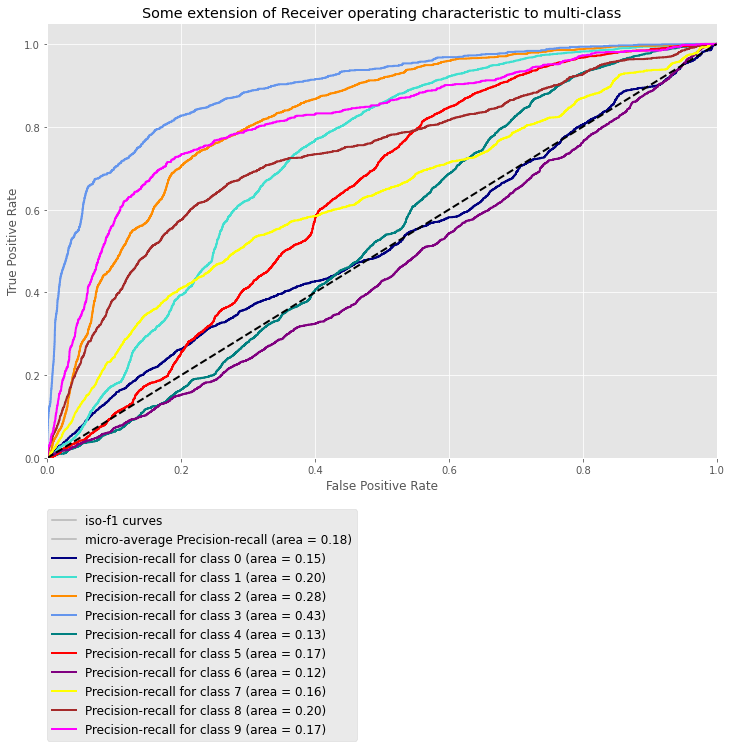

In [21]:
# plot all classes together
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

plt.figure(figsize=(12, 8))

colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=12))
plt.show()